baseline思路：使用CNN进行定长字符分类；

运行系统要求：Python2/3，内存4G，有无GPU都可以

In [1]:
import os, sys, glob, shutil, json
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import cv2

from PIL import Image
import numpy as np

from tqdm import tqdm, tqdm_notebook

%pylab inline

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

Populating the interactive namespace from numpy and matplotlib


In [2]:
device = torch.device("cuda:0")
device


device(type='cuda', index=0)

# 定义读取数据集

In [3]:
class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label 
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        lbl = np.array(self.img_label[index], dtype=np.int)
        lbl = list(lbl)  + (5 - len(lbl)) * [10]
        return img, torch.from_numpy(np.array(lbl[:5]))

    def __len__(self):
        return len(self.img_path)

# 定义读取数据dataloader

假设数据存放在`../input`文件夹下，并进行解压。

In [4]:
data_root = os.path.expanduser("~/NumReg/")
train_path = glob.glob(data_root+'train/*.png')
train_path.sort()
train_json = json.load(open(data_root+'train.json'))
train_label = [train_json[x]['label'] for x in train_json]
print(len(train_path), len(train_label))

train_loader = torch.utils.data.DataLoader(
    SVHNDataset(train_path, train_label,
                transforms.Compose([
                    transforms.Resize((64, 128)),
                    transforms.RandomCrop((60, 120)),
                    transforms.ColorJitter(0.3, 0.3, 0.2),
                    transforms.RandomRotation(10),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])), 
    batch_size=20, 
    shuffle=True
)

val_path = glob.glob(data_root+'val/*.png')
val_path.sort()
val_json = json.load(open(data_root+'val.json'))
val_label = [val_json[x]['label'] for x in val_json]
print(len(val_path), len(val_label))

val_loader = torch.utils.data.DataLoader(
    SVHNDataset(val_path, val_label,
                transforms.Compose([
                    transforms.Resize((60, 120)),
                    # transforms.ColorJitter(0.3, 0.3, 0.2),
                    # transforms.RandomRotation(5),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])), 
    batch_size=40, 
    shuffle=False
)

30000 30000
10000 10000


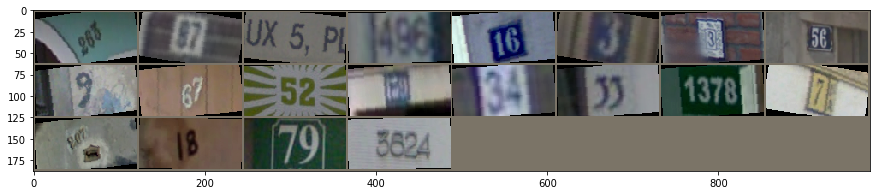

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15,20))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [6]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

NameError: name 'model_ft' is not defined

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# 定义分类模型

这里使用ResNet18的模型进行特征提取

In [ ]:
class SVHN_Model1(nn.Module):
    def __init__(self):
        super(SVHN_Model1, self).__init__()
                
        model_conv = models.resnet18(pretrained=True)
        model_conv.avgpool = nn.AdaptiveAvgPool2d(1)
        model_conv = nn.Sequential(*list(model_conv.children())[:-1])
        self.cnn = model_conv
        
        self.fc1 = nn.Linear(512, 11)
        self.fc2 = nn.Linear(512, 11)
        self.fc3 = nn.Linear(512, 11)
        self.fc4 = nn.Linear(512, 11)
        self.fc5 = nn.Linear(512, 11)
    
    def forward(self, img):        
        feat = self.cnn(img)
        # print(feat.shape)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        c5 = self.fc5(feat)
        return c1, c2, c3, c4, c5

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
    # 切换模型为训练模式
    model.train()
    train_loss = []
    preds_for_acc = []
    labels_for_acc = []
    pbar = tqdm(total = len(train_loader), desc='Training')
    for i, (input, target) in enumerate(train_loader):
        if use_cuda:
            input = input.cuda()
            target = target.cuda()
            
        c0, c1, c2, c3, c4 = model(input)
        target=target.long()
        loss = criterion(c0, target[:, 0]) + \
                criterion(c1, target[:, 1]) + \
                criterion(c2, target[:, 2]) + \
                criterion(c3, target[:, 3]) + \
                criterion(c4, target[:, 4])
        
        # loss /= 6
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
        #preds_for_acc = np.concatenate((preds_for_acc, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)
        train_loss.append(loss.item())
        pbar.update()
    
    #accuracy = accuracy_score(labels_for_acc, preds_for_acc)
    pbar.close()
    
    return np.mean(train_loss)

def validate(val_loader, model, criterion):
    # 切换模型为预测模型
    model.eval()
    val_loss = []

    # 不记录模型梯度信息
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            if use_cuda:
                input = input.cuda()
                target = target.cuda()
            
            c0, c1, c2, c3, c4 = model(input)
            target=target.long()
            loss = criterion(c0, target[:, 0]) + \
                    criterion(c1, target[:, 1]) + \
                    criterion(c2, target[:, 2]) + \
                    criterion(c3, target[:, 3]) + \
                    criterion(c4, target[:, 4])
            # loss /= 6
            val_loss.append(loss.item())
    return np.mean(val_loss)

def predict(test_loader, model, tta=10):
    model.eval()
    test_pred_tta = None
    
    # TTA 次数
    for _ in range(tta):
        test_pred = []
    
        with torch.no_grad():
            for i, (input, target) in enumerate(test_loader):
                if use_cuda:
                    input = input.cuda()
                
                c0, c1, c2, c3, c4 = model(input)
                if use_cuda:
                    output = np.concatenate([
                        c0.data.cpu().numpy(), 
                        c1.data.cpu().numpy(),
                        c2.data.cpu().numpy(), 
                        c3.data.cpu().numpy(),
                        c4.data.cpu().numpy()], axis=1)
                else:
                    output = np.concatenate([
                        c0.data.numpy(), 
                        c1.data.numpy(),
                        c2.data.numpy(), 
                        c3.data.numpy(),
                        c4.data.numpy()], axis=1)
                
                test_pred.append(output)
        
        test_pred = np.vstack(test_pred)
        if test_pred_tta is None:
            test_pred_tta = test_pred
        else:
            test_pred_tta += test_pred
    
    return test_pred_tta

# 训练与验证

In [ ]:
model = SVHN_Model1()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)
best_loss = 1000.0

use_cuda = True
if use_cuda:
    model = model.cuda()

for epoch in range(10):
    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_loss = validate(val_loader, model, criterion)
    
    val_label = [''.join(map(str, x)) for x in val_loader.dataset.img_label]
    val_predict_label = predict(val_loader, model, 1)
    val_predict_label = np.vstack([
        val_predict_label[:, :11].argmax(1),
        val_predict_label[:, 11:22].argmax(1),
        val_predict_label[:, 22:33].argmax(1),
        val_predict_label[:, 33:44].argmax(1),
        val_predict_label[:, 44:55].argmax(1),
    ]).T
    val_label_pred = []
    for x in val_predict_label:
        val_label_pred.append(''.join(map(str, x[x!=10])))
    
    val_char_acc = np.mean(np.array(val_label_pred) == np.array(val_label))
    
    print('Epoch: {0}, Train loss: {1} \t Val loss: {2}'.format(epoch, train_loss, val_loss))
    print('Val Acc', val_char_acc)
    # 记录下验证集精度
    if val_loss < best_loss:
        best_loss = val_loss
        # print('Find better model in Epoch {0}, saving model.'.format(epoch))
        #torch.save(model.state_dict(), './model.pt')

# 预测并生成提交文件

In [ ]:
test_path = glob.glob('../input/test_a/*.png')
test_path.sort()
test_json = json.load(open('../input/test_a.json'))
test_label = [[1]] * len(test_path)
print(len(test_path), len(test_label))

test_loader = torch.utils.data.DataLoader(
    SVHNDataset(test_path, test_label,
                transforms.Compose([
                    transforms.Resize((70, 140)),
                    # transforms.RandomCrop((60, 120)),
                    # transforms.ColorJitter(0.3, 0.3, 0.2),
                    # transforms.RandomRotation(5),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])), 
    batch_size=40, 
    shuffle=False, 
    num_workers=10,
)

In [ ]:
# 加载保存的最优模型
model.load_state_dict(torch.load('model.pt'))

test_predict_label = predict(test_loader, model, 1)
print(test_predict_label.shape)

test_label = [''.join(map(str, x)) for x in test_loader.dataset.img_label]
test_predict_label = np.vstack([
    test_predict_label[:, :11].argmax(1),
    test_predict_label[:, 11:22].argmax(1),
    test_predict_label[:, 22:33].argmax(1),
    test_predict_label[:, 33:44].argmax(1),
    test_predict_label[:, 44:55].argmax(1),
]).T

test_label_pred = []
for x in test_predict_label:
    test_label_pred.append(''.join(map(str, x[x!=10])))
    
import pandas as pd
df_submit = pd.read_csv('../input/test_A_sample_submit.csv')
df_submit['file_code'] = test_label_pred
df_submit.to_csv('submit.csv', index=None)